In [115]:
import os, glob
import json
from datetime import date
from tqdm import trange
import numpy as np

import cv2
from PIL import Image
import skimage.io as io
from skimage import measure
import matplotlib.pyplot as plt

from collections import OrderedDict
from pycocotools import mask 
from pycocotools.coco import COCO

In [29]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    # Fortran과 같은 순서로 인덱싱하여 배열(열 배열)
    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle    

# json 형식 맞추기였지만, 지금은 사용안함
# class BytesEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, bytes):
#             return obj.decode('utf-8')
#         return json.JSONEncoder.default(self, obj)

## COCO Instance Segmentation format

In [118]:
root_path = "/home/joo/Downloads/"
dt_type = "val2022"
target_img = list(map(lambda x : x, sorted(glob.glob(root_path+"crack/"+dt_type+"/*"))))
target = list(map(lambda x : x, sorted(glob.glob(root_path+"crack/panoptic_"+dt_type+"/*"))))
# target = list(map(lambda x : x, sorted(glob.glob(root_path+"crack_plan/masks/*"))))

if dt_type == "test2022":
    num = 1 # default
elif dt_type == "val2022":
    num = 860
elif dt_type == "train2022" :
    num = 5128

# coco json init
json_file = {"info":{"description":"KORAD 2022 Dataset","url":"https://www.sierrabase.co.kr/", 
"version":"1.0","year":2022,"contributor":"jylee","data_created":date.today().isoformat()},
"images":[],"annotations":[],
"categories":[{"supercategory":"korad","id":1,"name":"ConcreteCrack"}]} # Instance Segmentation version 

for index in trange(len(target_img)):
    # temp = cv2.imread(target[int(file.split(".")[0][-5:])-1],0) # origin
    temp = cv2.imread(target[index],0)
    height,width = temp.shape
    # mask_index = np.where(temp >= (230),1,0) # origin
    mask_index = np.where(temp != 0,1,0)

    cnt = 1
    y_num = 0
    
    json_file["images"].append({"id":int(target_img[index].split(".")[0][-5:]),
    "file_name":target_img[index].split(".")[0][-5:]+"."+target_img[index].split(".")[1],
    "height":height,"width":width})

    if len(mask_index[0]) < 1 :
        # background image 
        json_file["annotations"].append({"image_id":int(target_img[index].split(".")[0][-5:]),"id":num, "category_id":"","bbox":[],"area":"",
        "segmentation":[],"iscrowd":""})
        num = num + 1
        continue
    
    fortran_ground_truth_binary_mask = np.asfortranarray(mask_index)
    rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
    
    compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    area = mask.area(compressed_rle)
    bbox = mask.toBbox(compressed_rle)

    json_file["annotations"].append({"image_id":int(target_img[index].split(".")[0][-5:]),"id":num, "category_id":1,
    "bbox":mask.toBbox(compressed_rle).tolist(), # bbox : top-left-x, top-left-y, width, height
    "area":int(mask.area(compressed_rle)),"segmentation":rle,"iscrowd":0}) # if iscrowd == 0 : polygon if else iscrowd == 1 : RLE

    # print(json.dumps(json_file, ensure_ascii=False, indent=3))

    num = num + 1
    # break


# instances_train2022, instances_val2022, instances_test2022
with open("instances_"+dt_type+".json",'w', encoding='utf-8') as f:
    json.dump(json_file, f)

  2%|▏         | 94/4268 [01:19<1:26:45,  1.25s/it]

## COCO Panoptic Segmentation format

In [103]:
root_path = "/home/joo/Downloads/"
dt_type = "train2022"
target_img = list(map(lambda x : x, sorted(glob.glob(root_path+"crack/"+dt_type+"/*"))))
target = list(map(lambda x : x, sorted(glob.glob(root_path+"crack/panoptic_"+dt_type+"/*"))))

# coco annotations id calculate [R+G*256+B*256^2]
# ex) [0,153,204] == [B, G, R] == 204+153*256*0*256^2 == 39372
num = 39372 

# coco json init
json_file = {"info":{"description":"KORAD 2022 Dataset","url":"https://www.sierrabase.co.kr/", 
"version":"1.0","year":2022,"contributor":"jylee","data_created":date.today().isoformat()},
"images":[],"annotations":[],
"categories":[{"supercategory":"korad","isthing":1,"id":1,"name":"ConcreteCrack","color":[0,153,204]}]} # Panoptic Segmentation version 

for index in trange(len(target_img)):
    # temp = cv2.imread(target[int(file.split(".")[0][-5:])-1],0) # origin
    temp = cv2.imread(target[index],0)
    height,width = temp.shape
    # mask_index = np.where(temp >= (230),1,0) # origin
    mask_index = np.where(temp != 0,1,0)
    json_file["images"].append({"id":int(target_img[index].split(".")[0][-5:]),
    "file_name":os.path.basename(target_img[index]),
    "height":height,"width":width})

    mask_file_name = os.path.basename(target[index])
    # mask_file_name = target[index].split(".")[0][-5:]+".png"

    if len(mask_index[0]) < 1 :
        # background image 
        json_file["annotations"].append({"segments_info":[{"id":0, "category_id":"","bbox":[],"area":"","iscrowd":""}],
        "file_name":mask_file_name,"image_id":int(target_img[index].split(".")[0][-5:])})
        continue
    
    fortran_ground_truth_binary_mask = np.asfortranarray(mask_index)
    rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
    compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    area = int(mask.area(compressed_rle))
    bbox = mask.toBbox(compressed_rle)

    json_file["annotations"].append({"segments_info":[{"id":num, "category_id":1,"iscrowd":0,
    "bbox":bbox.tolist(), "area":area}],
    "file_name":mask_file_name,"image_id":int(target_img[index].split(".")[0][-5:])}) 
    
    # print(json.dumps(json_file, ensure_ascii=False, indent=3))
    # break

# panoptic_train2022, panoptic_val2022, panoptic_test2022
with open("panoptic_"+dt_type+".json",'w', encoding='utf-8') as f:
    json.dump(json_file, f)

# 밑에는 RLE test 와 이를 통한 cocoApi test

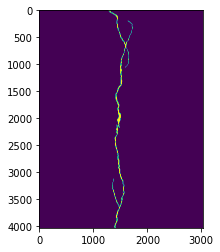

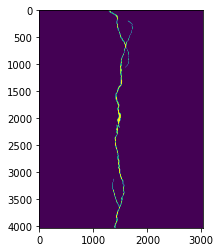

In [105]:
# 다중 폴리곤을 칸투어를 이용해 RLE format으로 Segmentation 하는거지만, Crack object와 같은 특성에서는 사용할 수 없었음.
def get_annotation(mask_img, image=None):

    contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    for contour in contours:
        # Valid polygons have >= 6 coordinates (3 points)
        if contour.size >= 6:
            segmentation.append(contour.flatten().tolist())

    RLEs = mask.frPyObjects(segmentation, mask_img.shape[0], mask_img.shape[1])
    RLE = mask.merge(RLEs)
    # RLE = cocomask.encode(np.asfortranarray(mask))
    area = mask.area(RLE)
    [x, y, w, h] = cv2.boundingRect(mask_img)

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.drawContours(image, contours, -1, (0,255,0), 1)
        cv2.rectangle(image,(x,y),(x+w,y+h), (255,0,0), 2)
        cv2.imshow("", image)
        cv2.waitKey(1)

    return segmentation, [x, y, w, h], area



a = cv2.imread("/home/joo/Downloads/crack_plan/masks/00489_GT.jpg", 0)
b = a.copy()
seg, bbox, area = get_annotation(mask_img=a)
# print(seg, bbox, area)

plt.imshow(a)
plt.show()
plt.close()

contours, _ = cv2.findContours(b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    b = cv2.drawContours(b, [contour], -1, (0,0,255),2)
plt.imshow(b)
plt.show()
plt.close()

{'counts': [6, 9, 3, 3], 'size': [3, 7]}
b'61X13mN000`0'
<class 'dict'>
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


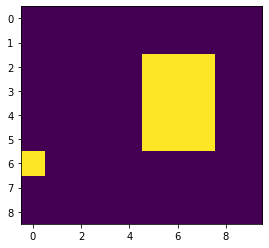

In [106]:
# test_list_1 = np.array([0, 0, 1, 1, 1, 0, 1])

test_list_1 = np.array([[0, 0, 1, 1, 1, 0, 1],
                        [0, 0, 1, 1, 1, 0, 1],
                        [0, 0, 1, 1, 1, 0, 1]])
# test_list_2 = np.array([1, 1, 1, 1, 1, 1, 0])

print(binary_mask_to_rle(test_list_1))
# print(binary_mask_to_rle(test_list_2))

ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)

compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
print(compressed_rle['counts'])
print(type(compressed_rle))
w = mask.decode(compressed_rle)
print(w)

plt.imshow(w)

In [107]:
coco = COCO('instances_test2022.json')

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['concreteCrack'])
imgIds = coco.getImgIds(catIds=catIds )
# print(imgIds)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
ConcreteCrack

COCO supercategories: 
korad


In [108]:
imgIds = coco.getImgIds(imgIds = [28691])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

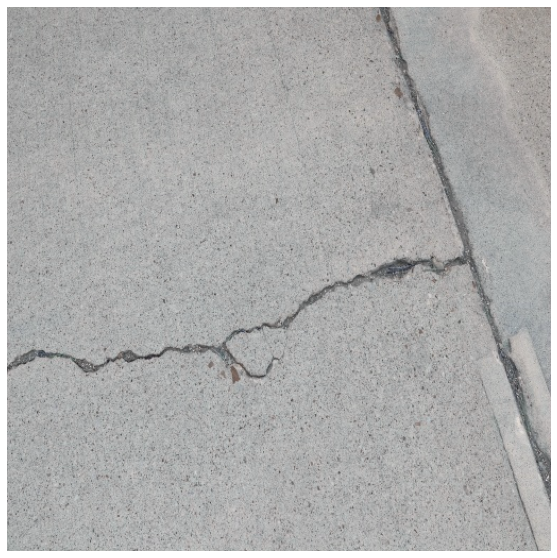

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'image_id': 28691, 'id': 857, 'category_id': 1, 'bbox': [0.0, 0.0, 0.0, 0.0], 'area': 0, 'segmentation': {'counts': [262144], 'size': [512, 512]}, 'iscrowd': 0}]


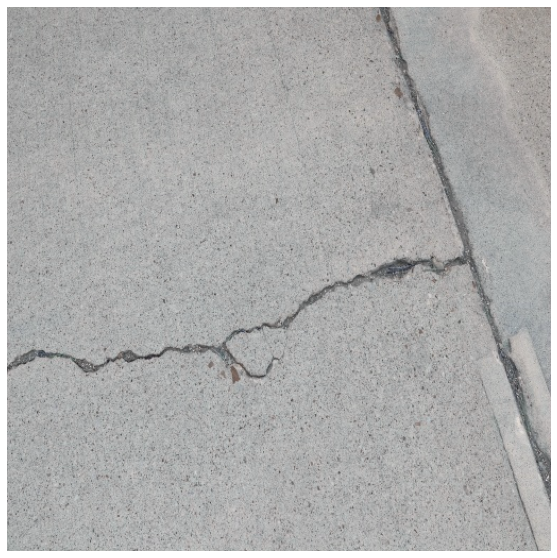

In [113]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(root_path+"crack/"+"test2022/"+img['file_name'])
I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display instance annotations
plt.figure(figsize=(10,10))
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

anns = coco.loadAnns(annIds)
print(anns)
# print(anns)
coco.showAnns(anns)
# plt.savefig('filename.png', bbox_inches='tight', pad_inches=0)


## COCO panoptic calculate id in annotations

In [ ]:
temp_img = cv2.imread("/home/joo/Downloads/coco/annotations/panoptic_val2017/000000000785.png")
# print(temp_img.shape)
print(temp_img[0][0], temp_img[0][0][2]+temp_img[0][0][1]*256+temp_img[0][0][0]*256*256)
print(temp_img[200][400],temp_img[200][400][2]+temp_img[200][400][1]*256+temp_img[200][400][0]*256*256)
print(temp_img[0][500],temp_img[0][500][2]+temp_img[0][500][1]*256+temp_img[0][500][0]*256*256)
print(temp_img[370][400],temp_img[370][400][2]+temp_img[370][400][1]*256+temp_img[370][400][0]*256*256)

plt.imshow(temp_img)

In [ ]:
import json
with open('instances_val2022.json', "r") as f: json_file = json.load(f)
print(json.dumps(json_file, ensure_ascii=False, indent=3))

In [ ]:
meta_dict_2 = {'thing_classes':['ConcreteCrack'],'thing_colors':[0,153,204],
'stuff_classes':['ConcreteCrack'],'stuff_colors':[0,153,204],
'thing_dataset_id_to_contiguous_id':{1:0},'stuff_dataset_id_to_contiguous_id':{2:1}}